In [1]:
from PIL import Image
import torch
from torchvision.transforms import (CenterCrop, Compose, Normalize, Resize,
                                    ToTensor)

def compute_gradient(func, inp, **kwargs):
    """Compute the gradient with respect to `inp`.

    Parameters
    ----------
    func : callable
        Function that takes in `inp` and `kwargs` and returns a single element
        tensor.

    inp : torch.Tensor
        The tensor that we want to get the gradients for. Needs to be a leaf
        node.

    **kwargs : dict
        Additional keyword arguments passed into `func`.

    Returns
    -------
    grad : torch.Tensor
        Tensor of the same shape as `inp` that is representing the gradient.
    """
    inp.requires_grad = True

    loss = func(inp, **kwargs)
    loss.backward()

    inp.requires_grad = False

    return inp.grad.data


def read_image(path):
    """Load image from disk and convert to torch.Tensor.

    Parameters
    ----------
    path : str
        Path to the image.

    Returns
    -------
    tensor : torch.Tensor
        Single sample batch containing our image (ready to be used with
        pretrained networks). The shape is `(1, 3, 224, 224)`.
    """
    img = Image.open(path)

    transform = Compose([Resize(256),
                         CenterCrop(224),
                         ToTensor(),
                         Normalize(mean=[0.485, 0.456, 0.406],
                                   std=[0.229, 0.224, 0.225])])

    tensor_ = transform(img)
    tensor = tensor_.unsqueeze(0)

    return tensor

def to_array(tensor):
    """Convert torch.Tensor to np.ndarray.

    Parameters
    ----------
    tensor : torch.Tensor
        Tensor of shape `(1, 3, *, *)` representing one sample batch of images.

    Returns
    -------
    arr : np.ndarray
        Array of shape `(*, *, 3)` representing an image that can be plotted
        directly.
    """
    tensor_ = tensor.squeeze()

    unnormalize_transform = Compose([Normalize(mean=[0, 0, 0],
                                               std=[1 / 0.229, 1 / 0.224, 1 / 0.225]),
                                     Normalize(mean=[-0.485, -0.456, -0.406],
                                               std=[1, 1, 1])])
    arr_ = unnormalize_transform(tensor_)
    arr = arr_.permute(1, 2, 0).detach().numpy()

    return arr

def scale_grad(grad):
    """Scale gradient tensor.

    Parameters
    ----------
    grad : torch.Tensor
        Gradient of shape `(1, 3, *, *)`.

    Returns
    -------
    grad_arr : np.ndarray
        Array of shape `(*, *, 1)`.
    """
    grad_arr = torch.abs(grad).mean(dim=1).detach().permute(1, 2, 0)
    grad_arr /= grad_arr.quantile(0.98)
    grad_arr = torch.clamp(grad_arr, 0, 1)

    return grad_arr.numpy()

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.models as models


def func(inp, net=None, target=None):
    """Compute negative log likelihood.

    Parameters
    ----------
    inp : torch.Tensor
        Input image (single image batch).

    net : torch.nn.Module
        Classifier network.

    target : int
        Imagenet ground truth label id.

    Returns
    -------
    loss : torch.Tensor
        Loss for the `inp` image.
    """
    out = net(inp)
    loss = torch.nn.functional.nll_loss(out, target=torch.LongTensor([target]))

    print(f"Loss: {loss.item()}")
    return loss

def attack(tensor, net, eps=1e-3, n_iter=50):
    """Run the Fast Sign Gradient Method (FSGM) attack.

    Parameters
    ----------
    tensor : torch.Tensor
        The input image of shape `(1, 3, 224, 224)`.

    net : torch.nn.Module
        Classifier network.

    eps : float
        Determines how much we modify the image in a single iteration.

    n_iter : int
        Number of iterations.

    Returns
    -------
    new_tensor : torch.Tensor
        New image that is a modification of the input image that "fools"
        the classifier.
    """
    new_tensor = tensor.detach().clone()

    orig_prediction = net(tensor).argmax()
    print(f"Original prediction: {orig_prediction.item()}")

    for i in range(n_iter):
        net.zero_grad()

        grad = compute_gradient(
                func, new_tensor, net=net, target=orig_prediction.item()
                )
        new_tensor = torch.clamp(new_tensor + eps * grad.sign(), -2, 2)
        new_prediction = net(new_tensor).argmax()

        if orig_prediction != new_prediction:
            print(f"We fooled the network after {i} iterations!")
            print(f"New prediction: {new_prediction.item()}")
            break

    return new_tensor, orig_prediction.item(), new_prediction.item()

# Label

In [16]:
import pandas as pd

label = pd.read_csv("/content/imagenet-simple-labels.json.txt", header=None)
label.drop(inplace = True, columns = 1)
label.iloc[0] = "tench"
label.iloc[-1] = "toilet paper"
label

,0
0,tench
1,goldfish
2,great white shark
3,tiger shark
4,hammerhead shark
...,...
995,earth star
996,hen-of-the-woods
997,bolete
998,ear of corn


In [30]:
label.iloc[0].values[0]

'tench'

# Load Model

In [4]:
net = models.resnet18(pretrained=True)

# Attack

In [20]:
import requests
from io import BytesIO
from PIL import Image
from functools import cache

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import torchvision.transforms as T
import torch
%matplotlib inline


def to_tuple(func):
    def wrapper(arg):
        if isinstance(arg, list):
            arg = tuple(arg)
        return func(arg)
    return wrapper


@to_tuple
@cache
def download_and_convert_to_tensor(urls):
    tensor_images = []
    for url in urls:
        response = requests.get(url, allow_redirects=True, headers={"User-Agent": "Mozilla/5.0"})
        img = Image.open(BytesIO(response.content))

        transform = Compose([Resize(256),
                         CenterCrop(224),
                         ToTensor(),
                         Normalize(mean=[0.485, 0.456, 0.406],
                                   std=[0.229, 0.224, 0.225])])

        tensor_ = transform(img)
        tensor = tensor_.unsqueeze(0)
        tensor_images.append(tensor)
        print(f"Downloaded an image of size {img.size}")

    return tensor_images

In [31]:
def plot_attack_result(orig_tensor, new_tensor, orig_prediction, new_prediction):
    arr = to_array(tensor)
    new_arr = to_array(new_tensor)
    diff_arr = np.abs(arr - new_arr).mean(axis=-1)
    diff_arr = diff_arr / diff_arr.max()

    ax_orig.imshow(arr)
    ax_new.imshow(new_arr)
    ax_diff.imshow(diff_arr, cmap="gray")

    ax_orig.axis("off")
    ax_new.axis("off")
    ax_diff.axis("off")

    ax_orig.set_title(f"Original: {orig_prediction}, label: {label.iloc[orig_prediction].values[0]}")
    ax_new.set_title(f"Modified: {new_prediction}, label: {label.iloc[new_prediction].values[0]}")
    ax_diff.set_title("Difference")


Original prediction: 291
Loss: -20.601346969604492
Loss: -19.41718864440918
Loss: -18.172224044799805
Loss: -16.982309341430664
Loss: -15.861790657043457
Loss: -14.782693862915039
Loss: -13.747716903686523
Loss: -12.775385856628418
Loss: -11.839067459106445
Loss: -10.954375267028809
Loss: -10.124897956848145
Loss: -9.350920677185059
Loss: -8.59338092803955
Loss: -7.853684425354004
Loss: -7.166627883911133
Loss: -6.5307416915893555
Loss: -5.917061805725098


We fooled the network after 16 iterations!
New prediction: 207


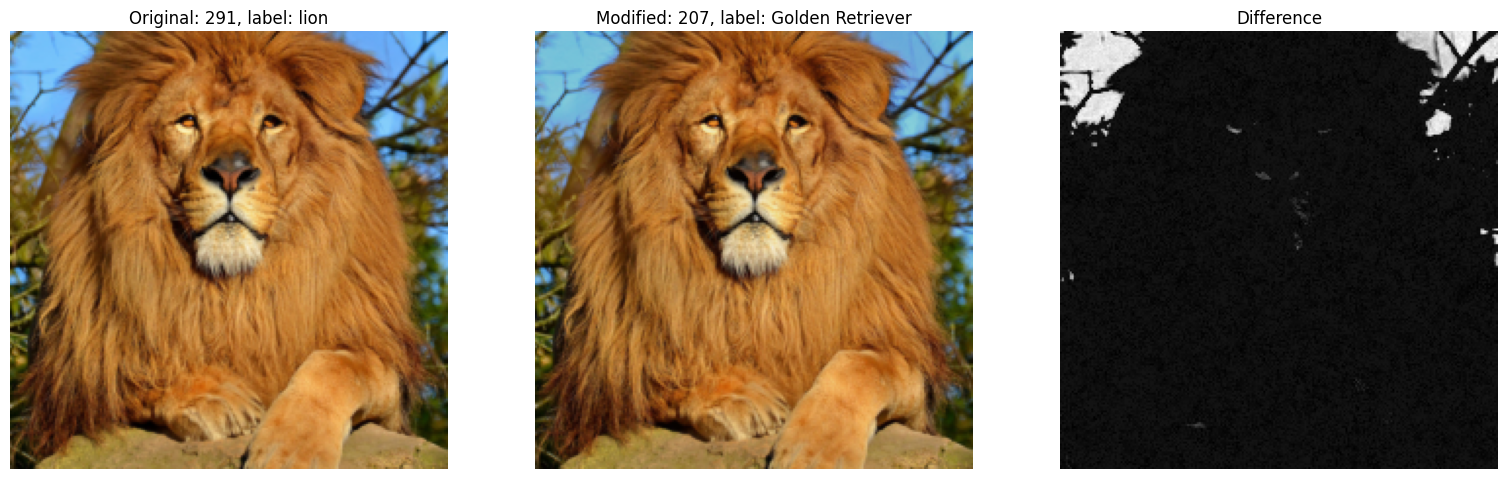

In [32]:
net.eval()

tensor = read_image("img.jpg")

new_tensor, orig_prediction, new_prediction = attack(tensor, net, eps=1e-3, n_iter=100)

_, (ax_orig, ax_new, ax_diff) = plt.subplots(1, 3, figsize=(19.20,10.80))

plot_attack_result(tensor, new_tensor, orig_prediction, new_prediction)


# Demo with 5 images

In [36]:
tensors = download_and_convert_to_tensor([
    'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQ0lhVXj22iQfv_t2Fw7J-IANSl-BITKux0qZojhR8vEg&s', # mèo
    'https://turbosmurfs.gg/storage/splash/Alistar_2.jpg', # trâu
    'https://images.contentstack.io/v3/assets/blt187521ff0727be24/bltfdc7d086a94d05ce/60ee13af43739d6620a57396/warwick-splash-updated.jpg', # sói
    'https://m.economictimes.com/thumb/height-450,width-600,imgsize-99562,msid-60988845/the-story-of-chinese-panda-and-its-diplomatic-strength.jpg', # panda
    'https://wallpapercave.com/wp/wp7380319.jpg' #nhện
])


Original prediction: 158
Loss: -7.808825492858887
We fooled the network after 0 iterations!
New prediction: 476
Original prediction: 917
Loss: -9.327496528625488
Loss: -8.446330070495605
Loss: -7.20892333984375


We fooled the network after 2 iterations!
New prediction: 599
Original prediction: 936
Loss: -8.02650260925293
We fooled the network after 0 iterations!
New prediction: 883
Original prediction: 633
Loss: -8.435821533203125
We fooled the network after 0 iterations!
New prediction: 850
Original prediction: 644
Loss: -6.20314884185791


We fooled the network after 0 iterations!
New prediction: 451


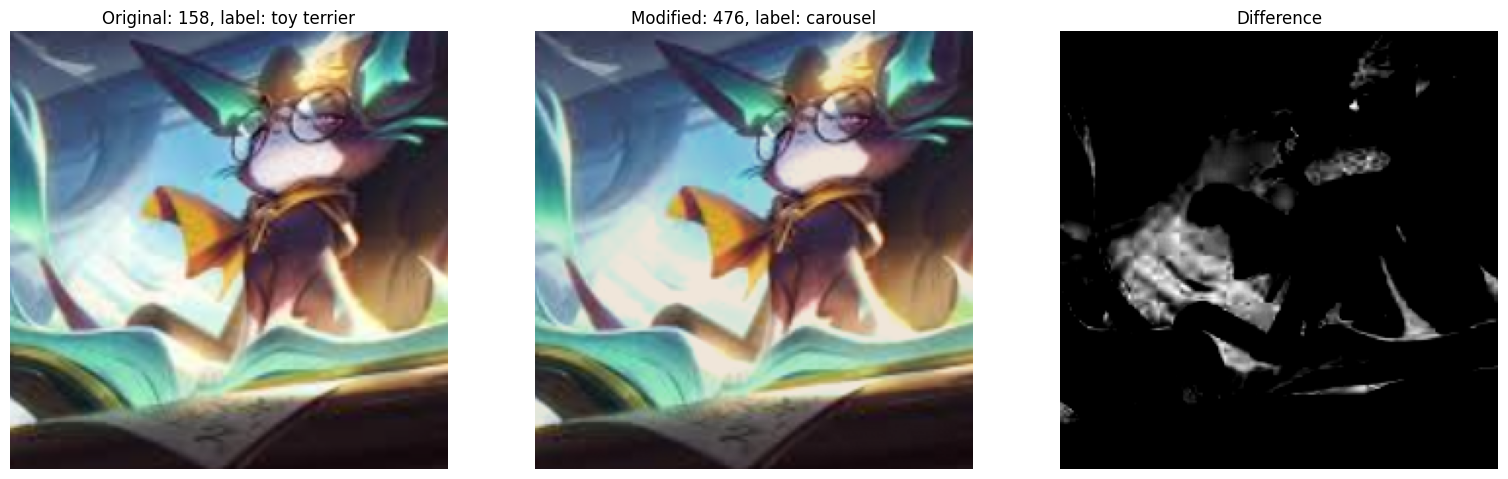

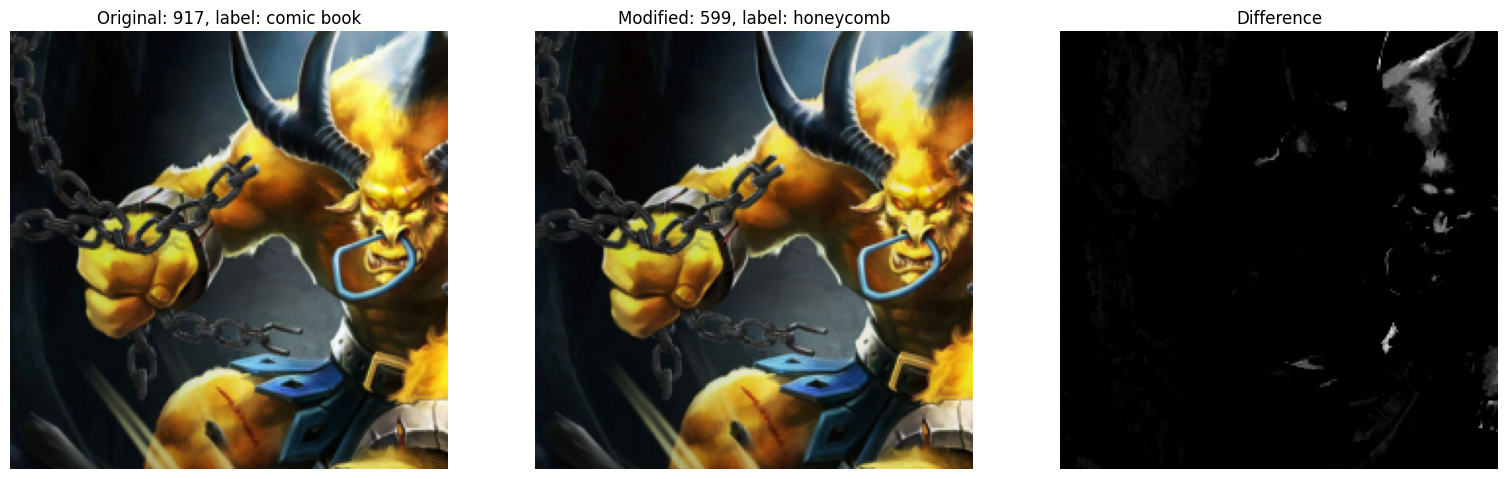

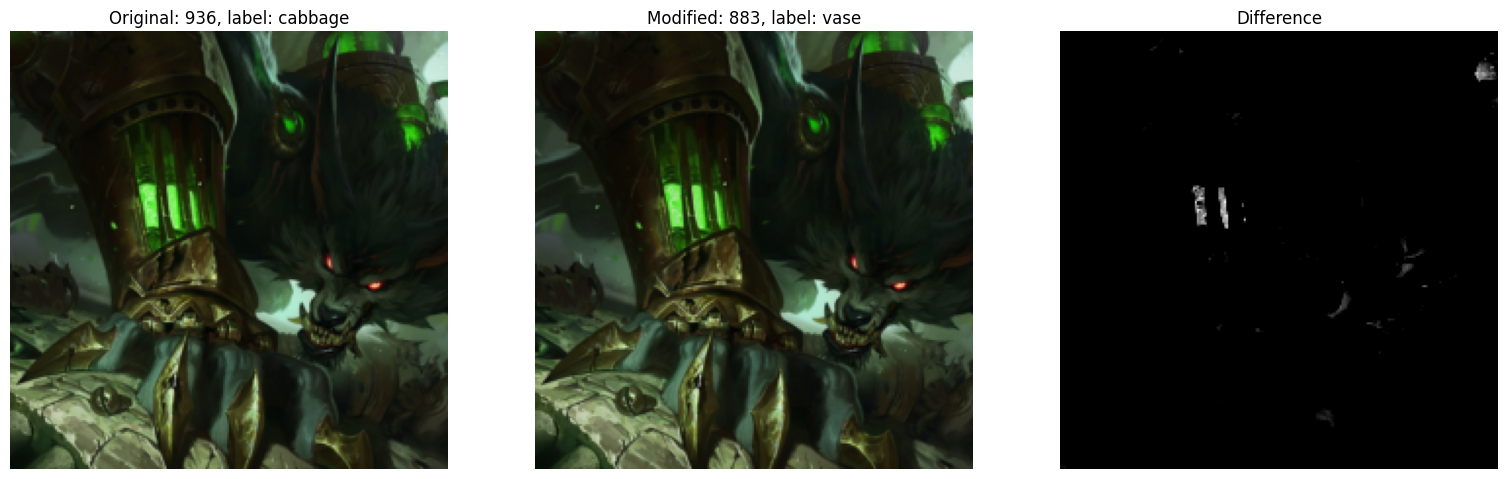

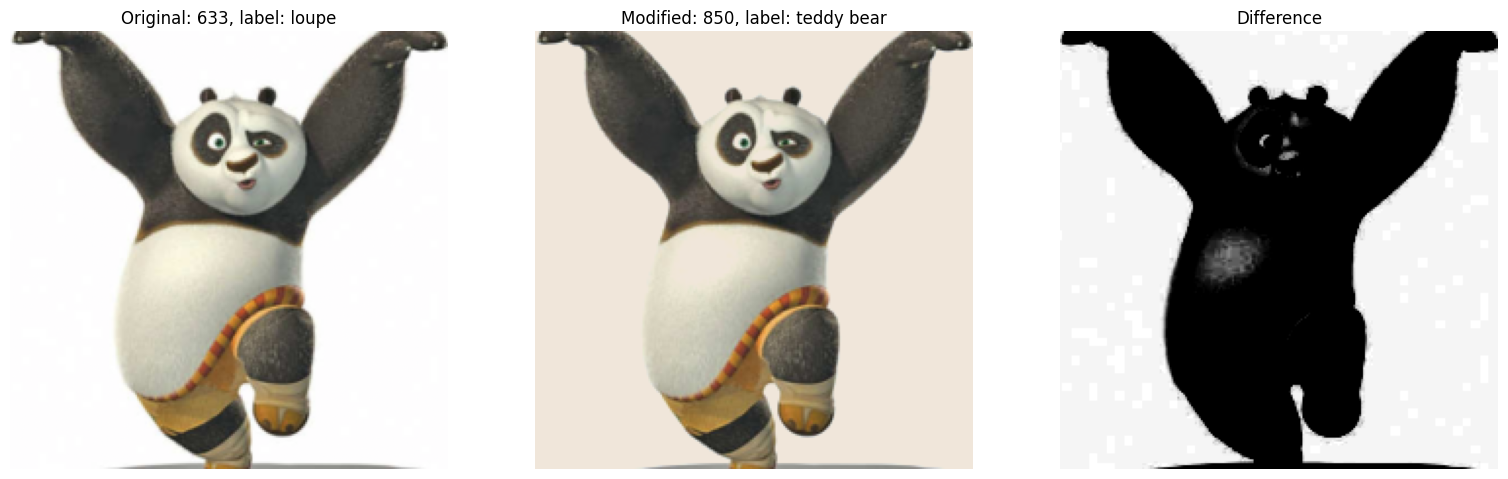

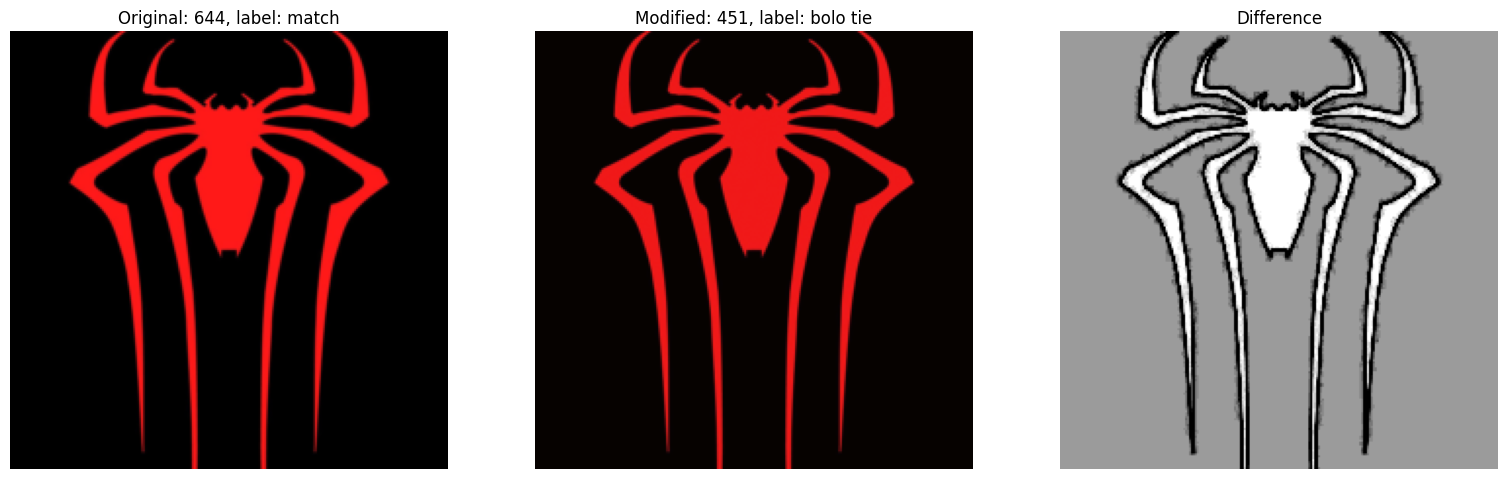

In [37]:
for i, tensor in enumerate(tensors):
    new_tensor, orig_prediction, new_prediction = attack(tensor, net, eps=1e-3, n_iter=100)

    _, (ax_orig, ax_new, ax_diff) = plt.subplots(1, 3, figsize=(19.20,10.80))

    plot_attack_result(tensor, new_tensor, orig_prediction, new_prediction)